# Skin segmentation

In this assignement you will train classifier to assign colors to skin or no skin classes. The data is taken from [Skin Segmentation Data Set](http://archive.ics.uci.edu/ml/datasets/Skin+Segmentation#) in the UCI Machine Learning repository.

The  data is in a plain text format and contains four columns. First three contain RGB color data  represented as integers in the range 0-255, and the last column is an integer label  with 1 representing skin and 2 representing no skin. This file we can load directly into a numpy array:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn

In [2]:
data = np.loadtxt('data/Skin_NonSkin.txt')

In [3]:
rgb  = data[:,:3].astype('float32')
lbl = data[:,3].astype('float32') 
lbl = 2-lbl # 1-skin, 0-not skin; >0.5 rcognized as skin

In [4]:
len(data)

245057

In [5]:
np.bincount(lbl.astype('int32'))

array([194198,  50859])

## Problem 1

Train the neural network to distinguish skin from no skin colors. Calculate the accuracy on train and validation sets. Calculate true positives rate and false positives rate.

In [6]:
model = nn.Sequential(
    nn.Linear(3, 30), # transforms incoming 3 features into output of 30 features
    nn.ReLU(), # Applies the rectified linear unit function element-wise
    nn.Linear(30, 60),
    nn.ReLU(),
    nn.Linear(60, 20),
    nn.ReLU(),
    nn.Linear(20, 1),
    nn.Sigmoid() # Applies the element-wise function
)

In [7]:
params = {
    'batch_size': 600,
    'num_workers': 10, #multi-process data loading
}

# data to pytorch Tensors
x_data = torch.from_numpy(rgb)
y_data = torch.from_numpy(lbl)

dataset = torch.utils.data.TensorDataset(x_data, y_data)
training_dataset, test_dataset = torch.utils.data.random_split(dataset, [179652, 65405])
training_generator = torch.utils.data.DataLoader(training_dataset, **params) 
test_generator = torch.utils.data.DataLoader(test_dataset, **params)

# np.bincount(training_dataset)

In [8]:
optimizer=torch.optim.SGD(model.parameters(), lr = 0.003)
loss_fn = nn.BCEWithLogitsLoss()
# loss_fn = nn.BCELoss()

In [9]:
%%time
epochs = 550
train_loss = []
test_acc_list = np.array([])

for e in range(epochs):    
    model.train() # setting model to training mode
    
    #training
    for local_x, local_y in training_generator:    
        optimizer.zero_grad()
        output = model(local_x) #calling model(x)  instead of forward(x); outputs predictions
        # loss = loss_fn(local_y.reshape(-1, 1), output)
        loss = loss_fn(output, local_y.reshape(-1, 1))
        
        loss.backward()
        optimizer.step()
    
        train_loss.append(loss.item())
    
    model.eval()
    with torch.set_grad_enabled(False):
        for local_x, local_y in test_generator:
            # test_pred = torch.sigmoid(model(local_x)) # prediction
            # test_tag = (test_pred < 0.5).type(torch.FloatTensor) # 0 / 1
            # # correct = (prediction == local_y).type(torch.FloatTensor)
            # # print(float(torch.mean(correct)))
            # test_acc_list.append(test_tag.cpu().numpy())
            local_y = local_y.reshape(-1, 1).type(torch.FloatTensor)
            test_pred = model(local_x)
            val_loss = loss_fn(local_y, test_pred)
            np.append(test_acc_list, val_loss.item())
        
    if e % 10 == 0:
        print(f"Epoch {str(e)} -> {str(loss.item())}")

Epoch 0 -> 0.7028648853302002
Epoch 10 -> 0.6980425715446472
Epoch 20 -> 0.6969514489173889
Epoch 30 -> 0.6963737607002258
Epoch 40 -> 0.6959874629974365
Epoch 50 -> 0.6956949234008789
Epoch 60 -> 0.6954588890075684
Epoch 70 -> 0.6952617168426514
Epoch 80 -> 0.6950927376747131
Epoch 90 -> 0.6949460506439209
Epoch 100 -> 0.6948169469833374
Epoch 110 -> 0.694702684879303
Epoch 120 -> 0.6946008801460266
Epoch 130 -> 0.6945096850395203
Epoch 140 -> 0.6944276094436646
Epoch 150 -> 0.694353461265564
Epoch 160 -> 0.6942861676216125
Epoch 170 -> 0.6942248940467834
Epoch 180 -> 0.6941689252853394
Epoch 190 -> 0.694117546081543
Epoch 200 -> 0.6940703392028809
Epoch 210 -> 0.6940268874168396
Epoch 220 -> 0.6939865946769714
Epoch 230 -> 0.6939494609832764
Epoch 240 -> 0.6939147710800171
Epoch 250 -> 0.6938825249671936
Epoch 260 -> 0.6938524842262268
Epoch 270 -> 0.6938244700431824
Epoch 280 -> 0.6937980651855469
Epoch 290 -> 0.6937734484672546
Epoch 300 -> 0.6937502026557922
Epoch 310 -> 0.6937284

In [ ]:
# test_acc_list = np.array([])

# #   testing
# model.eval()
# with torch.set_grad_enabled(False):
#     for local_x, local_y in test_generator:
#         # test_pred = torch.sigmoid(model(local_x)) # prediction
#         # test_tag = (test_pred < 0.5).type(torch.FloatTensor) # 0 / 1
#         # # correct = (prediction == local_y).type(torch.FloatTensor)
#         # # print(float(torch.mean(correct)))
#         # test_acc_list.append(test_tag.cpu().numpy())
#         local_y = local_y.reshape(-1, 1).type(torch.FloatTensor)
#         test_pred = model(local_x)
#         val_loss = loss_fn(local_y, test_pred)
#         np.append(test_acc_list, val_loss.item())
            

In [ ]:
# print(model.state_dict())

TypeError: expected np.ndarray (got Tensor)

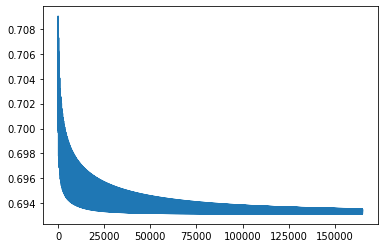

In [16]:
plt.plot(train_loss)
test_acc_list = torch.from_numpy(test_acc_list)
test_acc_list = torch.squeeze(test_acc_list)

plt.plot(test_acc_list, color="pink")
plt.show()